Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization

### Importing Data

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
root_data_path = "/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment"
# root_data_path = "../CNN_assignment"
data_dir_train = pathlib.Path(root_data_path + "/Train")
data_dir_test = pathlib.Path(root_data_path + '/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Let's define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Let's load these images off disk using the helpful `image_dataset_from_directory` utility. Using 80% of the images for training, and 20% for validation.

In [7]:
train_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels="inferred",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
  )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels="inferred",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
  )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:")
print(class_names)
print("Total classes: ",num_classes)

Classes:
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total classes:  9


#### Visualize the data

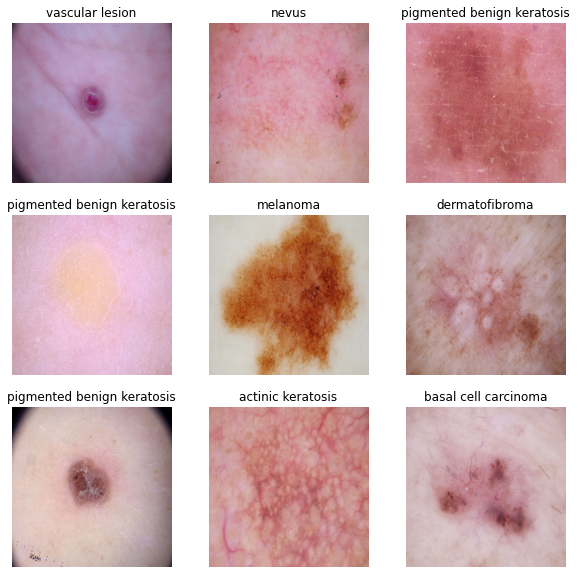

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating and evaluating model: 1st Iteration

#### Building a model

In [39]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

We are using `Rescaling` layer to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We added 2 CNN units and 1 dense layer

There are 9 clases for classification and we are using `softmax` as the output layer

#### Compiling the model

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

We used `adam` optimizer and `SparseCategoricalCrossentropy` as a loss function

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_15 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                      

#### Training the model

In [42]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 146ms/step - loss: 2.2433 - accuracy: 0.1897 - val_loss: 1.8673 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7590 - accuracy: 0.3544 - val_loss: 1.6416 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6131 - accuracy: 0.4202 - val_loss: 1.5367 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 5s 86ms/step - loss: 1.4931 - accuracy: 0.4710 - val_loss: 1.5604 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.3532 - accuracy: 0.5407 - val_loss: 1.5600 - val_accuracy: 0.4183
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.2691 - accuracy: 0.5502 - val_loss: 1.5169 - val_accuracy: 0.4631
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 1.1867 - accuracy: 0.5837 - val_loss: 1.5013 - val_accuracy: 0.4944
Epoch 8/20


Visualizing training results

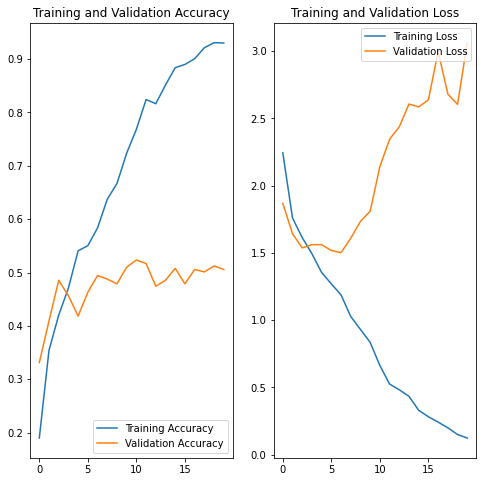

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
- Here we can see that the accuracy for training data is rising but for the validation its not
- The loss for  training data is reducing but for validation data its rising

Both the above points that the model is overfitting. Model is not able to find the patterns in the data but instead it have memorized the data

### Creating and evaluating model: 2nd Iteration

#### Augmentation layer

To handle the problem of overfitting lets add and Augmentation layer, this layer will randomly flip, zoom and rotate image to create variation, which will reduce the problem of overfitting

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

Let's visualize how your augmentation strategy works for one instance of training image.

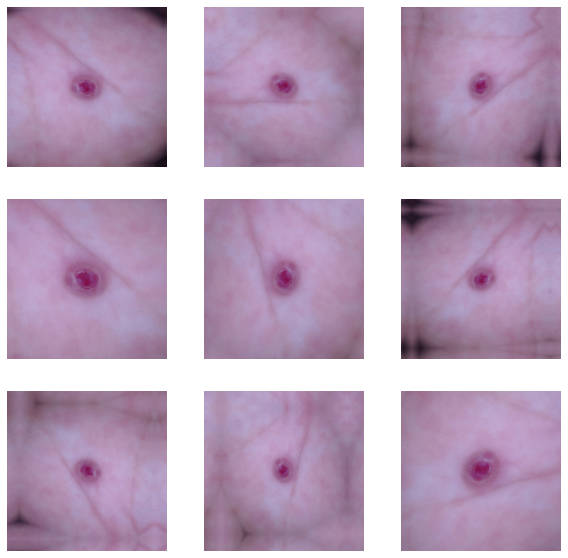

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Building a model

In [46]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Here we have used the same configuration having 2 CNN units but also added the augmentation layer along with dropouts. The output layer remains the same

#### Compiling the model

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Training the model

In [48]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 108ms/step - loss: 2.4424 - accuracy: 0.1691 - val_loss: 2.0791 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 6s 105ms/step - loss: 2.0333 - accuracy: 0.1897 - val_loss: 2.0154 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 105ms/step - loss: 2.0330 - accuracy: 0.1886 - val_loss: 2.0178 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 6s 105ms/step - loss: 2.0345 - accuracy: 0.1892 - val_loss: 2.0238 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 6s 105ms/step - loss: 2.0190 - accuracy: 0.2020 - val_loss: 2.0202 - val_accuracy: 0.3244
Epoch 6/20
56/56 [==============================] - 6s 105ms/step - loss: 1.9779 - accuracy: 0.2383 - val_loss: 1.9326 - val_accuracy: 0.2617
Epoch 7/20
56/56 [==============================] - 6s 105ms/step - loss: 1.9048 - accuracy: 0.2952 - val_loss: 1.8203 - val_accuracy: 0.3423
Epoch 

Visualizing the results

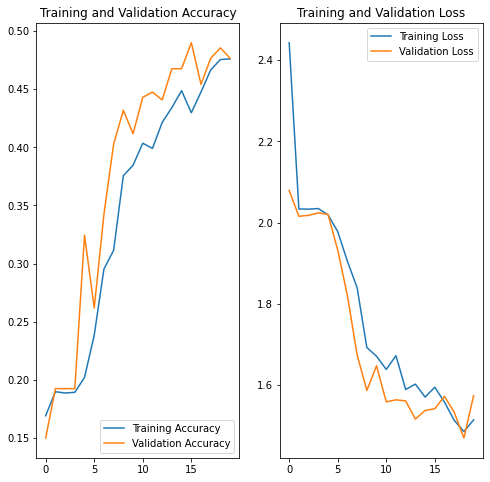

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
Here we can see that the overfitting has reduced overall. But, the overall train/validation accuracy has reduced

### Creating and evaluating model: 3rd Iteration

#### Class imbalance


Lets check what is the distribution of data across various classes

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [50]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts()
print(count)

5    370
3    352
1    309
4    277
7    142
8    115
0     92
2     77
6     58
dtype: int64


**Todo:** Write your findings here: 
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?


As you can see the classes are highly imbalance. We need to reduce this imbalance to have better results. Once way to reduce the imbalanance is by generating more image by using augmentor technique

#### Augmentor

Rectify the class imbalance we can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [14]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train.joinpath(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5AF00C6310>: 100%|██████████| 500/500 [00:24<00:00, 20.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B84BFE490>: 100%|██████████| 500/500 [00:24<00:00, 20.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5AF0041190>: 100%|██████████| 500/500 [00:21<00:00, 23.80 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F5AF01E4AD0>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F5B00A51710>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B84BFE490>: 100%|██████████| 500/500 [00:21<00:00, 22.88 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5B00A661D0>: 100%|██████████| 500/500 [00:47<00:00, 10.50 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5A851A0F90>: 100%|██████████| 500/500 [00:21<00:00, 23.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5AF00C6B50>: 100%|██████████| 500/500 [00:21<00:00, 22.80 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [15]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [16]:
post_augment_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.


In [17]:
dataset_unbatched = tuple(post_augment_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts()
print(count)

5    962
3    938
1    876
4    857
7    681
8    639
0    614
2    595
6    577
dtype: int64


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Lets train a model using this augmented data

#### Preparing data

Creating training and validation dataset which includes augmented images

In [18]:
train_aug_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [19]:
val_aug_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Building a model

Let's build a model on this newly formed data

In [1]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

NameError: ignored

We've considered 2 CNN units, which includes dropouts and BatchNormalization. The output is dense layer with `softmax` activation

#### Compiling a model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Training a model

In [ ]:
from keras.callbacks import ReduceLROnPlateau

epochs = 50
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)
history = model.fit(
  train_aug_ds,
  validation_data=val_aug_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/50
169/169 [==============================] - 50s 224ms/step - loss: 10.4298 - accuracy: 0.2081 - val_loss: 49.0665 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 37s 211ms/step - loss: 2.2265 - accuracy: 0.2378 - val_loss: 47.2480 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 37s 213ms/step - loss: 1.8962 - accuracy: 0.2596 - val_loss: 45.1247 - val_accuracy: 0.1418 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 36s 208ms/step - loss: 1.8255 - accuracy: 0.2849 - val_loss: 1.7100 - val_accuracy: 0.3623 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 37s 213ms/step - loss: 1.7713 - accuracy: 0.3008 - val_loss: 1.8412 - val_accuracy: 0.2895 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 38s 222ms/step - loss: 1.7279 - accuracy: 0.3229 - val_loss: 1.4983 - val_accuracy: 0.4068 - lr: 0.0010
Epoch 7/50
169/169 [============================

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

